In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date


from sklearn.linear_model import LinearRegression

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv(
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv', 
    header=None, 
    parse_dates=[0], 
    dtype={1: np.float16}, 
    names=['date', 'level_ppm']
)
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


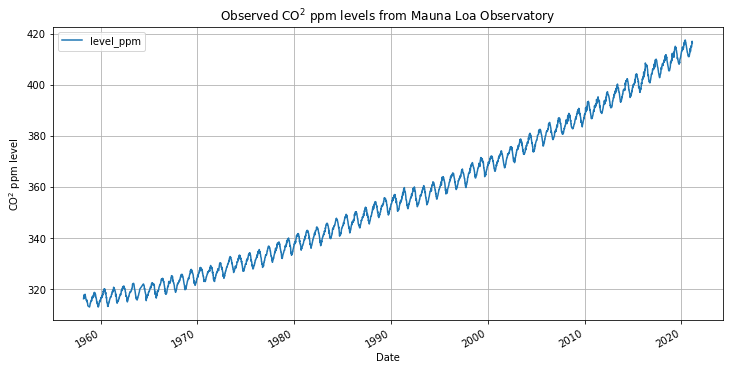

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [6]:
df['ordinal'] = df['date'].apply(datetime.toordinal)
df.head()

,date,level_ppm,ordinal
0,1958-03-29,316.25,714867
1,1958-04-05,317.25,714874
2,1958-04-12,317.75,714881
3,1958-04-19,317.50,714888
4,1958-04-26,316.50,714895


In [89]:
last_date = date(2060, 1, 1)
future_dates = pd.date_range(start=max(df['date']),end=last_date).to_series()
future_dates_ordinal = future_dates.apply(datetime.toordinal)
stan_data = {
    'N': len(df),
    'y': list(df['level_ppm']),
    'x': df['ordinal'],
    'nFutureCount': len(future_dates),
    'futureDays': future_dates_ordinal,
    'scalingFactor': 0.1
}
to_predict_dates = df['date'].append(future_dates)
to_predict = to_predict_dates.apply(datetime.toordinal)

In [101]:
# Generate starting points for the bad linear trend model
lr = LinearRegression(n_jobs=-1)
lr.fit(
    X = df[['ordinal']],
    y = df[['level_ppm']]
)

LinearRegression(n_jobs=-1)

In [9]:
%%time
bad_stan_model = pystan.StanModel(file='bad_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f92e3ed96dd0d2680d7a21a3f36e0903 NOW.
/Users/inventrohyder/anaconda3/envs/minerva/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/v4/6lzcc_4j4qn2hj39qtyjtc_80000gn/T/tmplm0h1vny/stanfit4anon_model_f92e3ed96dd0d2680d7a21a3f36e0903_9197399055859811353.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


CPU times: user 4.09 s, sys: 302 ms, total: 4.4 s
Wall time: 3min 36s


In [10]:
%%time
bad_parameters = ['t_intercept', 't_coef', 'c2', 'c3', 'sigma']
bad_results = bad_stan_model.sampling(
    data=stan_data,
    init=[{
        't_intercept': lr.intercept_[0],
        't_coef': lr.coef_[0][0]
    }] * 4
)
print(bad_results.stansummary(pars=bad_parameters))
bad_samples = bad_results.extract()

Inference for Stan model: anon_model_f92e3ed96dd0d2680d7a21a3f36e0903.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_intercept  -2812    0.12   6.89  -2826  -2815  -2811  -2808  -2798   3542    1.0
t_coef      4.4e-3  1.6e-7 9.5e-6 4.3e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   3541    nan
c2             2.8    0.03   0.09   2.64   2.73   2.78   2.86   3.01      8   1.13
c3           -1.45    0.26   0.36  -1.72  -1.67  -1.64  -1.16  -0.81      2   12.8
sigma         3.07    1.14   1.61   0.25    1.9   3.98   4.02    4.1      2   38.1

Samples were drawn using NUTS at Fri Apr 23 02:24:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 13.5 s, sys: 4.8 s, total: 18.3 s
Wall time: 28min 49s


In [67]:
def get_parameter(parameter:str, results, func = np.mean) -> float:
    return np.mean(results[parameter])

In [ ]:
# Model parameters
bad_t_intercept = get_parameter('t_intercept', bad_results)
bad_t_coef = get_parameter('t_coef', bad_results)
bad_c2 = get_parameter('c2', bad_results)
bad_c3 = get_parameter('c3', bad_results)

In [ ]:
# Stan model future predictions output
bad_prediction = bad_samples['x_future']

# Compute 95% interval of the predicted values
bad_prediction_interval = np.percentile(bad_prediction, axis=0, q=[2.5, 97.5])

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = bad_t_intercept + bad_t_coef* to_predict + bad_c2 * np.cos(2 * np.pi * to_predict / 365.25 + bad_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1960, 1, 1), 425, 
    r'Model equation: $c_0 + c_1 \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=17, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()

In [90]:
%%time
good_stan_model = pystan.StanModel(file='good_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a640925f67a59a3ebad3b2abd25056b NOW.
/Users/inventrohyder/anaconda3/envs/minerva/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/v4/6lzcc_4j4qn2hj39qtyjtc_80000gn/T/tmp7a3dbbn_/stanfit4anon_model_1a640925f67a59a3ebad3b2abd25056b_4274368553032209100.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


CPU times: user 967 ms, sys: 91.9 ms, total: 1.06 s
Wall time: 47.7 s


In [91]:
%%time
good_parameters = ['t_intercept', 'a', 'b', 'c', 'd', 'c2', 'c3', 'sigma']
good_results = good_stan_model.sampling(data=stan_data)
print(good_results.stansummary(pars=good_parameters))
good_samples = good_results.extract()

Inference for Stan model: anon_model_1a640925f67a59a3ebad3b2abd25056b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_intercept 231.03   74.65 105.57  52.56  145.1 274.15 312.52  331.9      2   39.8
a           1.2e-3  1.3e-3 1.8e-3 1.9e-5 2.1e-5 2.3e-4 2.5e-3 4.3e-3      2    nan
b              2.3    0.95   1.35    1.0    1.2   1.76   4.39    4.4      2   4.47
c           6.6e-3  7.1e-310.0e-3 4.4e-4 8.5e-4 1.3e-3 8.6e-3   0.03      2   6.63
d           -44.61   23.29  32.93 -96.63 -71.31  -39.7 -16.23  -9.66      2  48.03
c2             2.2     0.6   0.86   0.73   1.43   2.53   2.79   2.91      2  18.02
c3           -0.98    0.75   1.06  -1.68  -1.64  -1.56  -0.14   0.85      2  63.08
sigma         4.71    2.75   3.89   0.95   1.81   4.29   7.31  14.02      2   3.48

Samples were drawn using NUTS at Fri Apr 23 05:38:28 2021.
For 

In [92]:
# Model parameters
good_t_intercept = get_parameter('t_intercept', good_results)
good_a = get_parameter('a', good_results)
good_b = get_parameter('b', good_results)
good_c = get_parameter('c', good_results)
good_d = get_parameter('d', good_results)
good_c2 = get_parameter('c2', good_results)
good_c3 = get_parameter('c3', good_results)

In [93]:
# Stan model future predictions output
good_prediction = good_samples['x_future']

# Compute 95% interval of the predicted values
good_prediction_interval = np.percentile(good_prediction, axis=0, q=[2.5, 97.5])

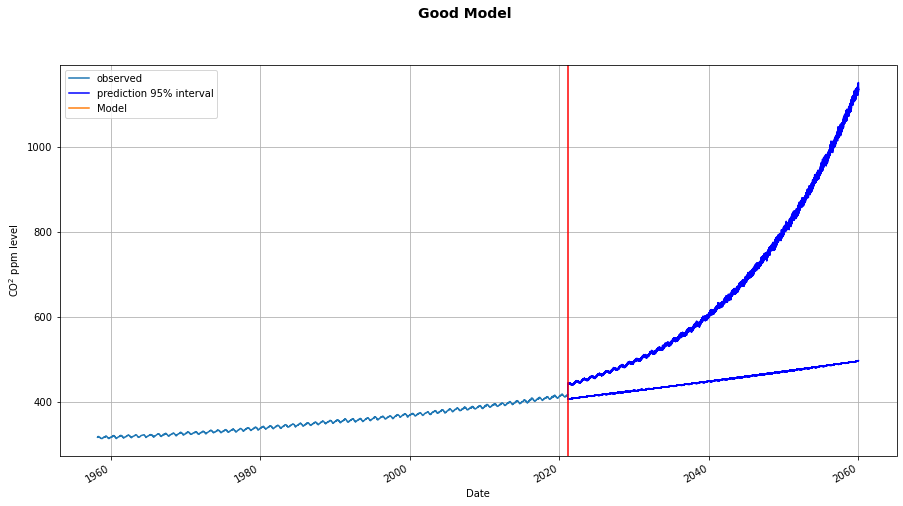

In [94]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Good Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = good_t_intercept + good_a * good_b**(good_c* to_predict + good_d) + good_c2 * np.cos(2 * np.pi * to_predict / 365.25 + good_c3)
# good_t_intercept + good_t_coef*np.exp(good_c2 * to_predict*stan_data['scalingFactor']) + good_c3 * np.cos(2 * np.pi * to_predict / 365.25 + good_c4)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()

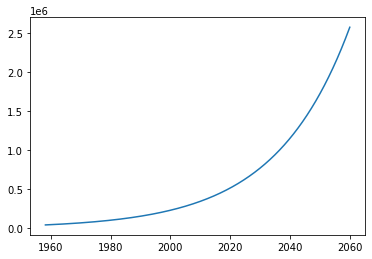

In [88]:
# model_predictions = 200 + 0.0001* 2**(0.0001* to_predict + -53)
# model_predictions=good_t_intercept + good_t_coef*np.exp(good_c2 * to_predict*stan_data['scalingFactor']) + good_c3 * np.cos(2 * np.pi * to_predict / 365.25 + good_c4)
model_predictions = good_t_intercept + good_a * good_b**(good_c* to_predict*0.1 + good_d) + good_c2 * np.cos(2 * np.pi * to_predict / 365.25 + good_c3)
plt.plot(to_predict_dates, model_predictions, label="Model")